**Example of minimiation of ground energy of Hamiltonians**
1. Cooling method
2. Cooling method with SDP

In [48]:
import argparse
import time
import random
import itertools
import numpy as np
import cvxpy as cp
import math
import scipy
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli, partial_trace, state_fidelity, random_density_matrix, random_statevector
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.monitor import job_monitor

from SDPforVQE import *
from SDPforVQE import *

In [49]:
def pauli_product(single_pauli_str1, single_pauli_str2):
    '''Compute the product of Pauli operators in an analytical way
    Example 1:
        INPUT: 'XI', 'IY' 
        OUTPUT: [1, 'XY'] (Because XI times IY is XY)
    Example 2:
        INPUT: 'X', 'Y' 
        OUTPUT: [1j, 'Z'] (Because X times Y is iZ)
    '''

    if single_pauli_str1 == 'I':
        return [1, single_pauli_str2]
    if single_pauli_str2 == 'I':
        return [1, single_pauli_str1]

    if single_pauli_str1 == 'X':
        if single_pauli_str2 == 'X':
            return [1, 'I']
        elif single_pauli_str2 == 'Y':
            return [1j, 'Z']
        elif single_pauli_str2 == 'Z':
            return [-1j, 'Y']
        
    if single_pauli_str1 == 'Y':
        if single_pauli_str2 == 'X':
            return [-1j, 'Z']
        elif single_pauli_str2 == 'Y':
            return [1, 'I']
        elif single_pauli_str2 == 'Z':
            return [1j, 'X']
        
    if single_pauli_str1 == 'Z':
        if single_pauli_str2 == 'X':
            return [1j, 'Y']
        elif single_pauli_str2 == 'Y':
            return [-1j, 'X']
        elif single_pauli_str2 == 'Z':
            return [1, 'I']

def pauli_commutator(pauli_str1, pauli_str2):
    '''Compute the commutator of two Pauli operators in an analytical way
    Example 1:
        INPUT: 'XI', 'IY' 
        OUTPUT: 0 (Because [XI,IY]=0)
    Example 2:
        INPUT: 'X', 'Y' 
        OUTPUT: [2j, Z] (Because [X,Y]=2iZ)
    '''
    num_negatives_1 = pauli_str1.count('-')
    num_negatives_2 = pauli_str2.count('-')
    phase = (-1) ** (num_negatives_1 + num_negatives_2)
    cleaned_pauli_str1 = pauli_str1.replace('-', '')
    cleaned_pauli_str2 = pauli_str2.replace('-', '')

    commutator = pauliToMatrix(cleaned_pauli_str1)*pauliToMatrix(cleaned_pauli_str2) - pauliToMatrix(cleaned_pauli_str2)*pauliToMatrix(cleaned_pauli_str1)
    
    if np.all(np.array(commutator) == 0):
        return 0 
    else:
        commutator_str = ''
        coef = 2
        for i in range(len(cleaned_pauli_str1)):
            result = pauli_product(cleaned_pauli_str1[i], cleaned_pauli_str2[i])
            commutator_str = commutator_str + result[1]
            coef = coef*result[0]
    
        return coef*phase, commutator_str

def qiskit_statevec_map(statevec_qiskit, N):
    '''Qiskit orders qubits in a endian way, 
       this function is used to convert a state vector that written in endian ordering to a normal ordering
    '''
    statevec_qiskit = np.array(statevec_qiskit)
    statevec_normal = np.zeros_like(statevec_qiskit, dtype=complex)
    
    for i in range(2**N):
        binary_index = format(i, f'0{N}b')  # Convert the index to an N-bit binary string
        reversed_index = int(binary_index[::-1], 2)  # Reverse the binary string and convert it back to an integer
        
        statevec_normal[reversed_index] = statevec_qiskit[i]

    return Statevector(statevec_normal)

def available_h_set(N, M, K, model_type):
    '''Get all the accessible operations according to the layout of the Hamiltonian of insterest'''

    h_set = set({})

    if model_type == 'open':
        for i in range(N):
            h_set.add('I'*i + 'X' + 'I'*(N-i-1))
            h_set.add('I'*i + 'Y' + 'I'*(N-i-1))
            h_set.add('I'*i + 'Z' + 'I'*(N-i-1))
        PauliStrList_part = generate_PauliStrList(M)[1:]
        for k in range(K):
            for basis in PauliStrList_part:
                h_set.add('I'*k + basis + 'I'*(N-k-M))

    if model_type == 'closed':
        for i in range(N):
            h_set.add('I'*i + 'X' + 'I'*(N-i-1))
            h_set.add('I'*i + 'Y' + 'I'*(N-i-1))
            h_set.add('I'*i + 'Z' + 'I'*(N-i-1))
        PauliStrList_part = generate_PauliStrList(M)[1:]
        for k in range(N-M+1):
            for basis in PauliStrList_part:
                h_set.add('I'*(k) + basis + 'I'*(N-k-M))
        for basis in PauliStrList_part:
            h_set.add(basis[0] + 'I'*(N-M) + basis[1])
            
    return h_set

def get_reduced_pauli_strings(pauli_str):
    '''Given a Pauli string, eliminate all "I", and thus leaves the reduced Pauli string
    Example:
        INPUT: 'XIZIIY' 
        OUTPUT: 'XZY'
    '''
    non_trivial_indices = []
    for i, char in enumerate(pauli_str): # Iterate through the characters in the Pauli string
        if char in ['X', 'Y', 'Z']: # Check if the character represents a non-trivial Pauli operator
            non_trivial_indices.append(i) # Append the index to the list of non-trivial indices

    return non_trivial_indices


In [50]:
def get_all_relevant_indices(h_set, H_global_list):
    '''Get the set of qubit indices of all the relevant reduced density matrices, 
       which are used to calculate A=<hHh-H> and B=i<hH-Hh>
    Args:
       h_set: Set of accessible Pauli operators in the lab
       H_global_list: A list Pauli strings which describes the global Hamiltonian
    '''
    set_of_indices = set({})

    for h in h_set:
        for H in H_global_list:
            cleaned_H = H.replace('-', '')
            tmp = pauli_commutator(h, cleaned_H)
            if tmp != 0:
                relevant_index = get_reduced_pauli_strings(tmp[1])
                set_of_indices.add(tuple(relevant_index))
                
    return set_of_indices

def get_rdm_dict(dm_Mbody, meas_dataset, 
                 h_set, H_global_list, N, M, K,
                 model_type):
    '''Get the dictionary for all relevant reduced density matrices required to calculate A=<hHh-H> and B=i<hH-Hh> 
    Args:
       dm_Mbody: A list of M-body density matrices, which can be obtained by SDP or just tomography
       meas_dataset: measurement dataset
       h_set: Set of accessible Pauli operators in the lab
       H_global_list: A list Pauli strings which describes the global Hamiltonian
    '''
    set_of_indices = get_all_relevant_indices(h_set, H_global_list)
    
    # Make a dictionary for all the relevant reduced density matrices
    dm_dict = {}
    for index in set_of_indices:
        dm_dict[tuple(index)] = np.array(q_tomography_dm(list(index), meas_dataset, N))
    
    # Replace the reduced density matrices that are associated with local Hamiltonians with dm_Mbody 
    # dm_Mbody can be obtained by SDP or just tomography
    if model_type=='open':
        for k in range(K):  # K: number of subsystem
            index = list(range(k, k + M, 1))  # [k, k+1, ...]
            dm_dict[tuple(index)] = dm_Mbody[index[0]]
    if model_type=='closed':
        for k in range(K):  # K: number of subsystems
            index = [(k + i) % K for i in range(M)]  # [k, k+1, ...]
            dm_dict[tuple(index)] = dm_Mbody[index[0]]
        
    return dm_dict

def evolved_rdm(layer_operators, rdm_index, rdm):
    '''Given layer operator and a reduced density matrix (and its index),
       compute the evolved reduced density matrix
    Args: 
       layer_operators: A layer of unitary operators
       rdm: density matrix to be evovled
       rdm_index: the qubit indices of the rdm
    '''
    register = list(range(len(rdm_index)))
    
    for operator_index in layer_operators: # Loop over every unitary operator in this layer

        overlap_index = list(set(tuple(rdm_index)) & set(operator_index))
        extra_I_index = list(set(tuple(rdm_index)) - set(operator_index))

        if len(overlap_index) > 0:
            h_best, B, t_opt, decrease = layer_operators[operator_index] # Fetch the operator associated with operator_index
            reduced_h = ''.join(h_best[i] for i in rdm_index) # Get the reduced Pauli strings (e.g.: 'XYIII' to 'XY')
            
            # Get the reduced operator 
            if (B < 0 and t_opt < 0):
                reduced_U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(reduced_h)) ) )
            elif (B <= 0 and t_opt >= 0):
                reduced_U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(reduced_h)) ) )
            elif (B >= 0 and t_opt <= 0):
                reduced_U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(reduced_h)) ) )
            elif (B > 0 and t_opt > 0):
                reduced_U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(reduced_h)) ) )
            
            # Evolve
            rdm = np.array( DensityMatrix(np.array(rdm)).evolve(reduced_U, register) )
 
    return rdm
    
def get_current_rdm(layer_operators, dm_dict):
    '''Given the layer operators and measurement dataset,
       comupte all the M-body reduced density matrices and single-qubit density matrices
    Args: 
       layer_operators: A layer of unitary operators
       dm_dict: The dictionary that stores all relevant reduced density matrices required to calculate A=<hHh-H> and B=i<hH-Hh> 
    '''
    dm_dict_new = {}
    
    for rdm_index in dm_dict: # Loop through every rdm in dm_dict
        rdm = dm_dict[rdm_index]
        dm_dict_new[tuple(rdm_index)] = evolved_rdm(layer_operators, rdm_index, rdm) # Get the evolved reduced density matrix
        
    return dm_dict_new

In [51]:
def find_h_best(dm_dict, h_set, H_global_list, N, M, K):
    '''Given the accessible set operations and the reduced density matrices,
       find the 'cooling' operation which leads to the maximal decrease of energy expection
    Args: 
       dm_dict: The dictionary that stores all relevant reduced density matrices required to calculate A=<hHh-H> and B=i<hH-Hh> 
       h_set: Set of accessible Pauli operators in the lab
       H_global_list: A list Pauli strings which describes the global Hamiltonian
    '''
    
    h_cool = [] # Set of h such that i<[h,H]> is smaller than 0 and the corresponding optimal time t_opt
    
    for h in h_set: # Loop through every Pauli operator in the accessible set h_set
        
        # Compute commutator [h,H]
        commutator_1st_list = [] # [h,H]
        for H in H_global_list:
            tmp = pauli_commutator(h, H)
            if tmp != 0:
                commutator_1st_list.append(tmp)

        # Get B = i<[h,H]>
        B_tmp = 0
        for commutator in commutator_1st_list:
            relevant_index = get_reduced_pauli_strings(commutator[1])
            rho = dm_dict[tuple(relevant_index)] # reduced density matrices
            commutator_sub = commutator[1].replace('I', '')
            exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
            B_tmp += exp*commutator[0]
        B = B_tmp*1j
        
        # Compute commutator [h,[h,H]]
        commutator_2nd_list = [] # [h,[h,H]]
        for h_H in commutator_1st_list:
            coef_1st = h_H[0]
            if pauli_commutator(h, h_H[1]) != 0:
                coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )
                
        # Get A = -1/2*<[h,[h,H]]>
        A_tmp = 0
        for commutator in commutator_2nd_list:
            relevant_index = get_reduced_pauli_strings(commutator[1])
            rho = dm_dict[tuple(relevant_index)] # reduced density matrices
            # if np.shape(rho) == ():   
            #     print(relevant_index)
            commutator_sub = commutator[1].replace('I', '')
            exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
            A_tmp += exp*commutator[0]
        A = -1/2*A_tmp

        #if A.real != 0 and B.real != 0:
        if A.real != 0:
            t_opt = 1/2*math.atan(-B.real/A.real) # The optimal time to evolve with
            decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2)) # The decrease
            h_cool.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, B, t_opt, decrease)

        # Select the operator h which leads to the most decrease
        if len(h_cool)>0:
            h_best, B, t_opt, decrease = max(h_cool, key=lambda x: abs(x[3]))
        else:
            h_best, B, t_opt, decrease = 'I'*N, 0, 0, 0
  
    return h_best, B, t_opt, decrease

In [52]:
def find_compatible_paulis(N, qubit_index):
    '''Find the set of Pauli operators that support qubits associated with the input qubit_index
    Args: 
       N: number of qubits of the whole system
       qubit_index: indices of qubits
    Example:
       INPUT: N=3, qubit_index=[2]
       OUTPUT: {IIX, IIY, IIZ}
    '''
    
    h_set = generate_PauliStrList(len(qubit_index))[1:]
    identity_string = 'I'*N
    
    new_h_set = []

    for pauli_string in h_set:
        new_string_list = list(identity_string)

        for i in qubit_index:
            new_string_list[i] = pauli_string[qubit_index.index(i)]

        new_h_set.append(''.join(new_string_list))

    return new_h_set

def find_incompatible_paulis(pauli_set, given_pauli):
    '''Find the set of Pauli operators that support qubits NOT associated with the input qubit_index
    Args: 
       pauli_set: set of pauli operator string
       given_pauli: a pauli string
    Example:
       INPUT: pauli_set = {XXI, YYY, ZZI, ZYY}, given_pauli={IIX}
       OUTPUT: {XXI, ZZI}
    '''
    # Find indices of non-'I' characters in the given Pauli string
    non_I_indices = [i for i, char in enumerate(given_pauli) if char != 'I']

    # Find Pauli strings in the set with 'I' at these indices
    incompatible_paulis = set()
    for pauli in pauli_set:
        if all(pauli[i] == 'I' for i in non_I_indices):
            incompatible_paulis.add(pauli)

    return incompatible_paulis

def find_layer_operator(dm_Mbody, meas_dataset, input_state, N_meas,
                        h_set, H_global_list, N, M, K,
                        num_of_sweep,
                        model_type):
    '''Find a layer operator of algorithmic cooling
    Args:
       dm_dict: The dictionary that stores all relevant reduced density matrices required to calculate A=<hHh-H> and B=i<hH-Hh> 
       h_set: Set of accessible Pauli operators in the lab
       H_global_list: A list Pauli strings which describes the global Hamiltonian
    '''
    
    layer_operators_list = [] # A list of operators that forms the layer
                              # Each element of this list refers to one 'sub-layer' of this layer operator
                              # For example, we have only one 'sub-layer' in this list if num_of_sweep=0, and two if num_of_sweep=1
    layer_operators = {} # Initialize the first sweep

    dm_dict = get_rdm_dict(dm_Mbody, meas_dataset, h_set, H_global_list, N, M, K, model_type)
    while len(h_set) != 0:
        # Get the operator which gives the most decrease
        h_best, B, t_opt, decrease = find_h_best(dm_dict, h_set, H_global_list, N, M, K)
        counter = 0
        while h_best == N*'I':
            counter = counter+1
            meas_dataset_new = generate_meas_dataset(input_state, N_meas, N) 
            
            dm = []
            if model_type=='open':
                for k in range(K):  # K: number of subsystems
                    index = list(range(k, k + M, 1))  # [k, k+1, ...]
                    dm.append(np.array(q_tomography_dm(index, meas_dataset_new, N)))
                dm_hat = dm.copy()
            if model_type=='closed':
                for k in range(K):  # K: number of subsystems
                    index = [(k + i) % K for i in range(M)]  # [k, k+1, ...]
                    dm.append(np.array(q_tomography_dm(index, meas_dataset_new, N)))
                dm_hat = dm.copy()

            dm_dict = get_rdm_dict(dm_hat, meas_dataset_new, h_set, H_global_list, N, M, K, model_type)
            h_best, B, t_opt, decrease = find_h_best(dm_dict, h_set, H_global_list, N, M, K)

        layer_operators[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
        
        # Evolve the reduced density matrices with this newly-getted operator
        new_operator = {} # Get the unitary operator we get
        new_operator[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
        dm_dict = get_current_rdm(new_operator, dm_dict)
        
        # Updated the accessible set of operators
        h_set = find_incompatible_paulis(h_set, h_best)
    
    layer_operators_list.append(layer_operators)
    
    # Get the layout of this layer operator
    layout = list(layer_operators.keys())
    
    # Do the sweep
    for i in range(num_of_sweep):

        sweep_operators = {}

        for qubit_index in layout:

            h_set = find_compatible_paulis(N, list(qubit_index))

            h_best, B, t_opt, decrease = find_h_best(dm_dict, h_set, H_global_list, N, M, K)
            sweep_operators[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
            
            new_operator = {}
            new_operator[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
            dm_dict = get_current_rdm(new_operator, dm_dict)

        layer_operators_list.append(sweep_operators)


    return layer_operators_list

def find_layer_operator_HF(dm_dict, h_set, H_global_list, N, M, K,
                        num_of_sweep):
    '''Find a layer operator of algorithmic cooling
    Args:
       dm_dict: The dictionary that stores all relevant reduced density matrices required to calculate A=<hHh-H> and B=i<hH-Hh> 
       h_set: Set of accessible Pauli operators in the lab
       H_global_list: A list Pauli strings which describes the global Hamiltonian
    '''
    
    layer_operators_list = [] # A list of operators that forms the layer
                              # Each element of this list refers to one 'sub-layer' of this layer operator
                              # For example, we have only one 'sub-layer' in this list if num_of_sweep=0, and two if num_of_sweep=1
    layer_operators = {} # Initialize the first sweep
    while len(h_set) != 0:
        # Get the operator which gives the most decrease
        h_best, B, t_opt, decrease = find_h_best(dm_dict, h_set, H_global_list, N, M, K)
        layer_operators[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
        
        # Evolve the reduced density matrices with this newly-getted operator
        new_operator = {} # Get the unitary operator we get
        new_operator[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
        dm_dict = get_current_rdm(new_operator, dm_dict)
        
        # Updated the accessible set of operators
        h_set = find_incompatible_paulis(h_set, h_best)
    
    layer_operators_list.append(layer_operators)
    
    # Get the layout of this layer operator
    layout = list(layer_operators.keys())
    
    # Do the sweep
    for i in range(num_of_sweep):

        sweep_operators = {}

        for qubit_index in layout:

            h_set = find_compatible_paulis(N, list(qubit_index))

            h_best, B, t_opt, decrease = find_h_best(dm_dict, h_set, H_global_list, N, M, K)
            sweep_operators[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
            
            new_operator = {}
            new_operator[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = tuple((h_best, B, t_opt, decrease))
            dm_dict = get_current_rdm(new_operator, dm_dict)

        layer_operators_list.append(sweep_operators)


    return layer_operators_list

In [53]:
def get_dm(N, qiskit_state, qubit_index):
    '''Given a multi-qubit state and index, 
       get the density matrix of the reduced state associated with the index
    Args:
       N: number of qubits of the whole system
       qiskit_state: a quantum state with qiskit structure
       qubit_index: indices of qubits of interest
    '''

    basis_list = generate_sub_PauliStrList(N, qubit_index)
    
    # First get the Bloch vector
    Bloch_vec = []
    for basis in basis_list:
        basis = basis[::-1] # Qiskit use endian, so we take the reverse here
        Bloch_vec.append(qiskit_state.expectation_value(oper=Pauli(basis), qargs=None))
    
    # Now compute the reduced density matrix
    dm = 0
    for i in range(4**len(qubit_index)-1):
        basis = basis_list[i]
        sub_basis = ''.join([basis[i] for i in qubit_index])
        dm += Bloch_vec[i] * pauliToMatrix(sub_basis)
    dm += tensor([qeye(2)] * len(qubit_index))

    return 1 / (2 ** len(qubit_index)) * dm

def get_HF_state(H_global_list, H_global_matrix, N, M, K, model_type):
    '''Get the product state with the lowest <H>
    Args:
       H_global_list: A list Pauli strings which describes the global Hamiltonian
       H_global_matrix: matrix representation of the global Hamiltonian in computational basis
    '''

    # Initialize state to a random tensor product state
    input_state = np.array(DensityMatrix(random_statevector(2))) # Make the first qubit a random pure state
    for i in range(N-1):
        statevec = random_statevector(2)
        dm = DensityMatrix(statevec)
        input_state = np.kron(input_state, np.array(dm))
    input_state = DensityMatrix(input_state) # This is an N-qubit random tensor product state

    h_set = available_h_set(N, M=1, K=N, model_type='open')
    set_of_indices = get_all_relevant_indices(h_set, H_global_list)

    exp_H_value = np.real(np.trace( np.matmul(input_state, H_global_matrix) ))
    exp_H_value_list = [exp_H_value]
    diff = 10
    
    qc = QuantumCircuit(N)

    while abs(diff) > 1e-4:

        exp_H_value_old = exp_H_value
        
        # Make a dictionary for all the relevant reduced density matrices
        dm_dict = {}
        for qubit_index in set_of_indices:
            dm_dict[tuple(qubit_index)] = np.array( get_dm(N, input_state, qubit_index) )
            
        # Find the layer operators that gives a decrease to <H>   
        layer_operators_list = find_layer_operator_HF(dm_dict, h_set, H_global_list, N, M, K, num_of_sweep=0)
    
        # Evolve the state with the obtained layer operators
        for i in range(len(layer_operators_list)):
            layer_operators = layer_operators_list[i]

            for qubit_index in layer_operators:
                register = list(qubit_index)
                h_best, B, t_opt, decrease = layer_operators[qubit_index]
                h_best_reduced = ''.join(char for char in h_best if char != 'I')
            
                if (B < 0 and t_opt < 0):
                    U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B <= 0 and t_opt >= 0):
                    U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B >= 0 and t_opt <= 0):
                    U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B > 0 and t_opt > 0):
                    U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                    
                input_state = input_state.evolve(U, register[::-1])
                qc.append(U, register[::-1])
        qc.barrier()

        exp_H_value = np.real(np.trace( np.matmul(input_state, H_global_matrix) ))
        exp_H_value_list.append(exp_H_value)
        diff = exp_H_value - exp_H_value_old

    qc.draw('mpl')

    return DensityMatrix(input_state), exp_H_value_list
    

In [17]:
def SDP_solver_min_C01(coef:float, 
                   ep:cp.expressions.variable.Variable, ep_C1:cp.expressions.variable.Variable, 
                   dm_tilde:cp.atoms.affine.add_expr.AddExpression, dm_tilde_C1:cp.atoms.affine.add_expr.AddExpression, 
                   H:np.ndarray, 
                   measurement_dataset:Dict[str,List[str]], 
                   N:int, M:int, G:int, K:int, P:int,
                   model_type:str) -> (float, float, float):
    '''Solve the SDP minimization problem with constraints C0 and C0+C1
    '''
    
    dm_tilde_copy01 = dm_tilde

    # Solve SDP with conditions C1+C0
    constraints_0 = constraints_C0(ep, coef, dm_tilde_copy01, measurement_dataset, N, M, K, P, model_type)
    constraints_1 = constraints_C1(ep_C1, coef, dm_tilde_copy01, dm_tilde_C1, measurement_dataset, N, M, G, K, model_type)
    H_exp01 = 0
    for i in range(K):
        H_exp01 = H_exp01 + H @ dm_tilde_copy01[i]
    prob_C01 = cp.Problem(
        cp.Minimize(
            cp.real(
                cp.trace(
                    H_exp01
                )
            )
        ), constraints_0 + constraints_1
    )
    energy_C01 = prob_C01.solve(solver=cp.SCS, verbose=False)
    if prob_C01.status != cp.OPTIMAL:
        energy_C01 = float('inf') 
  
    dm_SDP = []
    for i in range(K):
        dm_SDP.append(dm_tilde_copy01[i].value)

    return energy_C01, dm_SDP

def biSection_search_min_C01(higher_bound:float, threshold:float, 
                         ep:cp.expressions.variable.Variable, ep_C1:cp.expressions.variable.Variable, 
                         dm_tilde:cp.atoms.affine.add_expr.AddExpression, dm_tilde_C1:cp.atoms.affine.add_expr.AddExpression, 
                         H:np.ndarray, 
                         measurement_dataset:Dict[str,List[str]], 
                         N:int, M:int, G:int, K:int, P:int,
                         model_type:str) -> (float, float, float, float):
    '''Use bi-search method to find the minimum value of the relaxation such that there exists at least one solution in the search space,
       with an accuracy of 'threshold'
    '''

    low = 0
    high = higher_bound
    max_iter = 10
   
    energy_C01, dm_SDP = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)
    coef = high
    
    
    # If no solution exists within the initial higher bounds, increase the higher bound.
    while (math.isinf(energy_C01)) and max_iter > 0:
        low = high
        high = 2*high
        max_iter = max_iter-1
        energy_C01, dm_SDP = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)

    # If still no solution after expanding the bounds, return an error message.
    if max_iter == 0:
        return "No solution found within the search bounds and maximum iterations."
    
    # Perform the binary search within the updated bounds.
    while abs(high - low) >= threshold:
        coef = low + abs(high - low) / 2
        energy_C01_result, dm_SDP = SDP_solver_min_C01(coef, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)
        if (math.isinf(energy_C01_result)):
            low = coef
        else:
            high = coef
            energy_C01 = energy_C01_result

    return energy_C01, dm_SDP, coef

In [18]:
def algorithmic_cooling(input_state, N_opt, N_meas,
                        N, M, G, K, P, 
                        PauliStrList_part, PauliStrList_Gbody, h_set,
                        H_global_list, H_local_matrix,
                        higher_bound, threshold,
                        model_type,
                        SDP_tag, num_of_sweep):
    '''Do the algorithmic cooling
    '''
    # Get the energy of the initial input state
    E = 0
    for pauli_str in H_global_list:
        num_negatives = pauli_str.count('-')
        phase = (-1) ** num_negatives
        cleaned_pauli_string = pauli_str.replace('-', '')
        E = E + phase*input_state.expectation_value(oper=Pauli(cleaned_pauli_string), qargs=None)

    # Define lists for saving the results
    expH_dm_iter = [E]
    expH_dm_SDPvalue_iter = [E]

    # Start the optimization
    for i in tqdm(range(N_opt)):
        # Meas
        meas_dataset = generate_meas_dataset(input_state, N_meas, N)

        # Get the density matrix by tomography and SDP, respectively. 
        # Also get the minimized energy by SDP.
        ep = cp.Variable((K, P)) # SDP variables
        if model_type=='open':
            K_3body = N-G+1 # Number of 3-body subsystems
        if model_type=='closed':
            K_3body = K # Number of 3-body subsystems
        ep_C1 = cp.Variable((K_3body, 4**G-1)) # SDP variables for global verification
        dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                            N, M, K, P, 
                                            PauliStrList_part, model_type)
        
        # Solve the SDP problem
        if SDP_tag:
            dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                    N, G, K, 
                                    PauliStrList_Gbody, model_type)
            # Energy with SDP - minimum
            E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                                    ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                                    H_local_matrix, meas_dataset, 
                                                                                    N, M, G, K, P,
                                                                                    model_type
                                                                                    ) # dm_SDP is the density matrices by SDP
     
            expH_dm_SDPvalue_iter.append(E_min_C01_value) # Save the solved SDP min. value
            layer_operators_list = find_layer_operator(dm_SDP, meas_dataset, input_state, N_meas,
                                                       h_set, H_global_list, N, M, K,
                                                       num_of_sweep,
                                                       model_type)
            
        else:
            layer_operators_list = find_layer_operator(dm_hat, meas_dataset, input_state, N_meas,
                                                       h_set, H_global_list, N, M, K,
                                                       num_of_sweep,
                                                       model_type)

        # Get the expectation value <H>
        exp_H_new = 0
        for H in H_global_list:
            exp, var = exp_var_calculator(meas_dataset, H)
            exp_H_new += exp
        expH_dm_iter.append(exp_H_new) # Save the expectation value <H>

        # Evolve the state with the calculated layer operator 
        for i in range(len(layer_operators_list)): # The length of layer_operators_list corresponds to how many sweeps we do in each iteration 
                
            layer_operators = layer_operators_list[i]

            for qubit_index in layer_operators:
                register = list(qubit_index)
                h_best, B, t_opt, decrease = layer_operators[qubit_index]
                h_best_reduced = ''.join(char for char in h_best if char != 'I')
            
                if (B < 0 and t_opt < 0):
                    U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B <= 0 and t_opt >= 0):
                    U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B >= 0 and t_opt <= 0):
                    U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B > 0 and t_opt > 0):
                    U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                    
                input_state = input_state.evolve(U, register[::-1])
    
    return expH_dm_iter, expH_dm_SDPvalue_iter

def get_figure(avg_expH, std_expH, 
               avg_expH_enhanced, std_expH_enhanced, 
               avg_expH_enhanced_SDPvalue, std_expH_enhanced_SDPvalue, 
               ground_state_energy,
               initial_guess, N, N_opt, N_meas):
    '''Draw and plot the figure
    '''
    
    plt.figure()
    iteration_list = range(N_opt+1)
    
    # Plot the theoretical ground state energy
    plt.axhline(y = ground_state_energy, color='r', linestyle='-', linewidth=1.25, label='GS energy')

    # Plot the case without SDP
    plt.plot(iteration_list, avg_expH, linewidth=0.75, marker='s', markersize=2.5, label='Tomography')
    plt.fill_between(iteration_list, 
                    avg_expH-std_expH, avg_expH+std_expH, 
                    alpha=0.3)

    # Plot the case with SDP
    plt.plot(iteration_list, avg_expH_enhanced, linewidth=0.75, marker='s', markersize=2.5, label='SDP-Enhanced')
    plt.plot(iteration_list, avg_expH_enhanced_SDPvalue, linewidth=0.75, marker='o', markersize=2.5, label='SDP-Enhanced-min.')
    plt.fill_between(iteration_list, 
                    avg_expH_enhanced-std_expH_enhanced, avg_expH_enhanced+std_expH_enhanced, 
                    alpha=0.3)
    plt.fill_between(iteration_list, 
                    avg_expH_enhanced_SDPvalue-std_expH_enhanced_SDPvalue, avg_expH_enhanced_SDPvalue+std_expH_enhanced_SDPvalue, 
                    alpha=0.3)


    titlename = 'Initial:' + initial_guess + ', $N=$' + str(N) + ', $N_{meas}=$' + str(int(N_meas))
    plt.title(titlename)
    plt.xlabel('Number of iterations')
    plt.ylabel('Energy expectation')
    plt.legend()

    figurename = 'N' + str(N) + '_Meas' + str(int(N_meas)) + '_'+ initial_guess +  '.pdf'
    plt.savefig(figurename)

    # Show the plot
    plt.show()

In [19]:
def main(initial_guess, N_opt, N_meas, num_of_shots,
         N, M, G, H_local_list, model_type):
    
    # Get the useful parameters and constants for this function
    if model_type == 'open':
        K = N-M+1 # Number of subsystems
    if model_type == 'closed':
        K = N
    P = 4**M-1 # Number of Pauli basis for each subsystem
    PauliStrList_part = generate_PauliStrList(M)[1:]
    PauliStrList_Gbody = generate_PauliStrList(G)[1:]
    h_set = available_h_set(N, M, K, model_type)
    H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
    H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
    H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
    higher_bound = 1 # Starting trial value for the bi-search method
    threshold = 1 # Accuracy of the minimum relaxation value 
    ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 

    # Initial state
    if initial_guess == 'HF':
        input_state, exp_H_value_list = get_HF_state(H_global_list, H_global_matrix, N, M, K, model_type) # The HF state (the product state with the lowest <H>)
    if initial_guess == '00':
        tmp = np.zeros(2**N)
        tmp[0] = 1
        input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
    if initial_guess == '++':
        tmp = np.zeros(2**N)
        tmp[0] = 1
        input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
        Hadamard = Operator(np.array(1/2**0.5*(qutip.sigmax()+qutip.sigmaz()))) 
        for i in range(N):
            input_state = input_state.evolve(Hadamard, [i])
    
    # Define lists for saving the results
    expH_matrix = []
    expH_enhanced_matrix = []
    expH_enhanced_SDPvalue_matrix = []

    # Do the algorithmic cooling for many times
    for i in tqdm(range(num_of_shots)):
        # Without SDP
        expH, expH_SDPvalue = algorithmic_cooling(input_state, N_opt, N_meas,
                                                  N, M, G, K, P, 
                                                  PauliStrList_part, PauliStrList_Gbody, h_set,
                                                  H_global_list, H_local_matrix,
                                                  higher_bound, threshold,
                                                  model_type,
                                                  SDP_tag=False, num_of_sweep=0)
        expH_matrix.append(expH)
        # With SDP
        expH_enhanced, expH_enhanced_SDPvalue = algorithmic_cooling(input_state, N_opt, N_meas,
                                                                    N, M, G, K, P, 
                                                                    PauliStrList_part, PauliStrList_Gbody, h_set,
                                                                    H_global_list, H_local_matrix,
                                                                    higher_bound, threshold,
                                                                    model_type,
                                                                    SDP_tag=True, num_of_sweep=0)
        expH_enhanced_matrix.append(expH_enhanced)
        expH_enhanced_SDPvalue_matrix.append(expH_enhanced_SDPvalue)

    # Calculate the avg and std of cases WITHOUT SDP
    avg_expH= np.mean(np.array(expH_matrix), axis=0)
    std_expH = np.std(np.array(expH_matrix), axis=0)/(num_of_shots**0.5)

    # Calculate the avg and std of cases WITH SDP
    avg_expH_enhanced= np.mean(np.array(expH_enhanced_matrix), axis=0)
    std_expH_enhanced= np.std(np.array(expH_enhanced_matrix), axis=0)/(num_of_shots**0.5)
    avg_expH_enhanced_SDPvalue = np.mean(np.array(expH_enhanced_SDPvalue_matrix), axis=0)
    std_expH_enhanced_SDPvalue = np.std(np.array(expH_enhanced_SDPvalue_matrix), axis=0)/(num_of_shots**0.5)
    
    # Draw and save the figure
    get_figure(avg_expH, std_expH, 
               avg_expH_enhanced, std_expH_enhanced, 
               avg_expH_enhanced_SDPvalue, std_expH_enhanced_SDPvalue, 
               ground_state_energy,
               initial_guess, N, N_opt, N_meas)

    return avg_expH, std_expH, avg_expH_enhanced, std_expH_enhanced, avg_expH_enhanced_SDPvalue, std_expH_enhanced_SDPvalue, ground_state_energy
        

100%|██████████| 10/10 [00:31<00:00,  3.11s/it]
/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 1/1 [07:11<00:00, 431.07s/it]


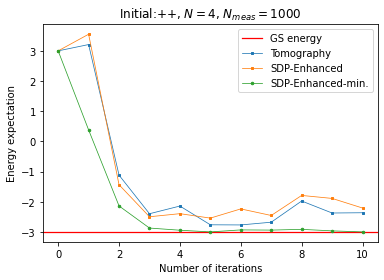

In [146]:
H_local_list = ['XX','-YY','ZZ'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

N_opt = 10 # Number of iterations of cooling
num_of_shots = 1 # Number of experiments we do 

data = []
for N in [4]: # Number of qubits of the entire system
    for N_meas in [1000]: # Number of measurements in all basis each loop
        for initial_guess in ['++']:
            avg_expH, std_expH, avg_expH_enhanced, std_expH_enhanced, avg_expH_enhanced_SDPvalue, std_expH_enhanced_SDPvalue, ground_state_energy = main(initial_guess, N_opt, N_meas, num_of_shots, 
                                                                                                                                                N, M, G, H_local_list, model_type)
            for i in list(range(N_opt+1)):
                # Save data to Panda DataFrame
                df = {
                    'N_opt': i,
                    'avg_expH': avg_expH[i],
                    'std_expH': std_expH[i],
                    'avg_expH_enhanced': avg_expH_enhanced[i],
                    'std_expH_enhanced': std_expH_enhanced[i],
                    'avg_expH_enhanced_SDPvalue': avg_expH_enhanced_SDPvalue[i],
                    'std_expH_enhanced_SDPvalue': std_expH_enhanced_SDPvalue[i],
                    'N': N,
                    'N_meas': N_meas,
                    'Initial_state': initial_guess
                }
                data.append(df)

df = pd.DataFrame(data)
df.to_csv('experiment_data.csv', index=False) # Save the DataFrame to a CSV file

100%|██████████| 2/2 [06:56<00:00, 208.20s/it]


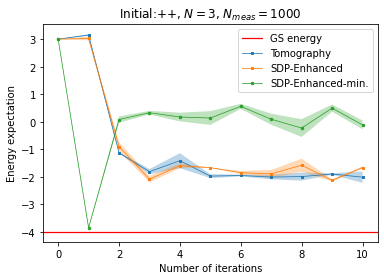

In [ ]:
H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'closed'
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

N_opt = 10 # Number of iterations of cooling
num_of_shots = 2 # Number of experiments we do 

data = []
for N in [3]: # Number of qubits of the entire system
    for N_meas in [1000]: # Number of measurements in all basis each loop
        for initial_guess in ['++']:
            avg_expH, std_expH, avg_expH_enhanced, std_expH_enhanced, avg_expH_enhanced_SDPvalue, std_expH_enhanced_SDPvalue, ground_state_energy = main(initial_guess, N_opt, N_meas, num_of_shots, 
                                                                                                                                                N, M, G, H_local_list, model_type)
            for i in list(range(N_opt+1)):
                # Save data to Panda DataFrame
                df = {
                    'N_opt': i,
                    'avg_expH': avg_expH[i],
                    'std_expH': std_expH[i],
                    'avg_expH_enhanced': avg_expH_enhanced[i],
                    'std_expH_enhanced': std_expH_enhanced[i],
                    'avg_expH_enhanced_SDPvalue': avg_expH_enhanced_SDPvalue[i],
                    'std_expH_enhanced_SDPvalue': std_expH_enhanced_SDPvalue[i],
                    'N': N,
                    'N_meas': N_meas,
                    'Initial_state': initial_guess
                }
                data.append(df)

df = pd.DataFrame(data)
df.to_csv('experiment_data.csv', index=False) # Save the DataFrame to a CSV file

In [124]:
N = 4
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
num_of_sweep = 0

H_local_list = ['XX','-YY','ZZ'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
# Get the useful parameters and constants for this function
if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N

N_opt = 5 # Number of iterations of cooling
num_of_shots = 1 # Number of experiments we do 
N_meas = 1000 # Number of measurements in all basis each loop
initial_guess = '++'


P = 4**M-1 # Number of Pauli basis for each subsystem
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]
h_set = available_h_set(N, M, K, model_type)
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value 
ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 

In [128]:
vec[:,0]

array([-0.00139225+0.j, -0.16581923+0.j, -0.31739952+0.j,  0.00139225+0.j,
       -0.16581923+0.j,  0.14981734+0.j,  0.00139225+0.j,  0.16581923+0.j,
       -0.31739952+0.j,  0.00139225+0.j, -0.68160784+0.j,  0.31739952+0.j,
        0.00139225+0.j,  0.16581923+0.j,  0.31739952+0.j, -0.00139225+0.j])

In [130]:
value, vec = np.linalg.eigh(H_global_matrix)

statevec = Statevector(vec[:,1])
dm = np.array(DensityMatrix(statevec))

global_state = Qobj(dm.reshape((16,16)), dims=[[2,2,2,2],[2,2,2,2]])
rdm = np.array(global_state.ptrace([1,2]))

np.trace(np.matmul(rdm,rdm))

(0.47839036468089+0j)

In [114]:
np.trace(np.matmul(dm, H_global_matrix))

(-0.557982920973363+0j)

In [139]:
HF_state_dm, exp_H_value_list = get_HF_state(H_global_list, H_global_matrix, N, M, K, model_type)
exp_H_value_list

[-0.34886723127551506,
 -2.4002739785712626,
 -2.9277271612776725,
 -2.981221839932734,
 -2.997727511565164,
 -2.9993265245286356,
 -2.999774293088807,
 -2.999963086314186,
 -2.9999874601078176]

In [144]:
HF_state = Qobj((np.array(HF_state_dm)).reshape((16,16)), dims=[[2,2,2,2],[2,2,2,2]])
HF_rdm = np.array(HF_state.ptrace([0,1]))

np.trace(np.matmul(HF_rdm, HF_rdm))

(0.9999999999999994-5.898059818321144e-17j)

In [145]:
np.trace(np.matmul(H_global_matrix, np.array(HF_state)))

(-2.9999874601078176-1.3010426069826053e-17j)

In [78]:
global_state = Qobj(ground_state_dm.reshape((16,16)), dims=[[2,2,2,2],[2,2,2,2]])
rdm = np.array(global_state.ptrace([1,2]))

In [79]:
np.trace(np.matmul(rdm,rdm))

(0.7280999798158182+0j)

In [71]:
np.trace(np.matmul(HF_rdm,HF_rdm))

(1.0000000000000009+3.469446951953614e-18j)

In [26]:
N = 4
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
num_of_sweep = 0

H_local_list = ['XX','-YY','ZZ'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
# Get the useful parameters and constants for this function
if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N

N_opt = 5 # Number of iterations of cooling
num_of_shots = 1 # Number of experiments we do 
N_meas = 1000 # Number of measurements in all basis each loop
initial_guess = '++'


P = 4**M-1 # Number of Pauli basis for each subsystem
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]
h_set = available_h_set(N, M, K, model_type)
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value 
ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 

# Initial state
if initial_guess == 'HF':
    input_state, exp_H_value_list = get_HF_state(H_global_list, H_global_matrix, N, M, K, model_type) # The HF state (the product state with the lowest <H>)
if initial_guess == '00':
    tmp = np.zeros(2**N)
    tmp[0] = 1
    input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
if initial_guess == '++':
    tmp = np.zeros(2**N)
    tmp[0] = 1
    input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
    Hadamard = Operator(np.array(1/2**0.5*(qutip.sigmax()+qutip.sigmaz()))) 
    for i in range(N):
        input_state = input_state.evolve(Hadamard, [i])

# expH_enhanced, expH_enhanced_SDPvalue = algorithmic_cooling(input_state, N_opt, N_meas,
#                                                             N, M, G, K, P, 
#                                                             PauliStrList_part, PauliStrList_Gbody, h_set,
#                                                             H_global_list, H_local_matrix,
#                                                             higher_bound, threshold,
#                                                             model_type,
#                                                             SDP_tag=True, num_of_sweep=0)



# Get the energy of the initial input state
E = 0
for pauli_str in H_global_list:
    num_negatives = pauli_str.count('-')
    phase = (-1) ** num_negatives
    cleaned_pauli_string = pauli_str.replace('-', '')
    E = E + phase*input_state.expectation_value(oper=Pauli(cleaned_pauli_string), qargs=None)

# Define lists for saving the results
expH_dm_iter = [E]
expH_dm_SDPvalue_iter = [E]

# Start the optimization
for i in tqdm(range(N_opt)):
    # Meas
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. 
    # Also get the minimized energy by SDP.
    ep = cp.Variable((K, P)) # SDP variables
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1)) # SDP variables for global verification
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type)
    
    # Solve the SDP problem
    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                N, G, K, 
                                PauliStrList_Gbody, model_type)
    
    low = 0
    high = higher_bound
    max_iter = 10
   
    energy_C01, dm_SDP = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H_local_matrix, meas_dataset, N, M, G, K, P, model_type)
    print(energy_C01)

    layer_operators_list = find_layer_operator(dm_SDP, meas_dataset, input_state, N_meas,
                                                       h_set, H_global_list, N, M, K,
                                                       num_of_sweep,
                                                       model_type)
    
    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expH_dm_iter.append(exp_H_new) # Save the expectation value <H>

    # Evolve the state with the calculated layer operator 
    for i in range(len(layer_operators_list)): # The length of layer_operators_list corresponds to how many sweeps we do in each iteration 
            
        layer_operators = layer_operators_list[i]

        for qubit_index in layer_operators:
            register = list(qubit_index)
            h_best, B, t_opt, decrease = layer_operators[qubit_index]
            h_best_reduced = ''.join(char for char in h_best if char != 'I')
        
            if (B < 0 and t_opt < 0):
                U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B <= 0 and t_opt >= 0):
                U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B >= 0 and t_opt <= 0):
                U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B > 0 and t_opt > 0):
                U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                
            input_state = input_state.evolve(U, register[::-1])

input_state

  0%|          | 0/5 [00:00<?, ?it/s]

-1.5989898329942738


 20%|██        | 1/5 [00:04<00:17,  4.39s/it]

-1.5769752816259106


 40%|████      | 2/5 [00:13<00:22,  7.38s/it]

-2.944967294810216


 60%|██████    | 3/5 [00:31<00:24, 12.06s/it]

-2.7395461098170406


 80%|████████  | 4/5 [00:36<00:09,  9.19s/it]

-2.891915708783636


100%|██████████| 5/5 [00:46<00:00,  9.32s/it]


In [57]:
np.trace(np.matmul(np.array(input_state), np.array(H_global_matrix)))

(-2.0986509019228703-1.942890293094024e-16j)

In [43]:
input_state = np.array(input_state)
global_state = Qobj(input_state.reshape((16,16)), dims=[[2,2,2,2],[2,2,2,2]])
global_state.ptrace([0,1])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.00685896-3.43683618e-18j -0.0398828 -3.75124611e-02j
   0.04206117+3.97619686e-02j -0.0149607 -1.76805320e-03j]
 [-0.0398828 +3.75124611e-02j  0.46548249+9.86623977e-17j
  -0.47358423-1.76805320e-03j  0.10184073-7.52561376e-02j]
 [ 0.04206117-3.97619686e-02j -0.47358423+1.76805320e-03j
   0.49314104-2.55329612e-17j -0.10401911+7.75056463e-02j]
 [-0.0149607 +1.76805320e-03j  0.10184073+7.52561376e-02j
  -0.10401911-7.75056463e-02j  0.03451751-1.42301535e-19j]]

In [50]:
gs_dm = Qobj(ground_state_dm.reshape((16,16)), dims=[[2,2,2,2],[2,2,2,2]])
gs_dm.ptrace([0,1])


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.12824235 -0.02482277  0.21699494 -0.12824235]
 [-0.02482277  0.07743921  0.1045215   0.02482277]
 [ 0.21699494  0.1045215   0.6660761  -0.21699494]
 [-0.12824235  0.02482277 -0.21699494  0.12824235]]

In [27]:
expH_dm_iter

[2.999999999999998,
 2.9600922954905258,
 -1.0120040954558287,
 -4.052118892826857,
 -3.8271585588302317,
 -4.180324349928833]

In [29]:
ground_state_energy

-3.0000000000000013

In [ ]:
N = 3
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
num_of_sweep = 0

H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
# Get the useful parameters and constants for this function
if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N

N_opt = 5 # Number of iterations of cooling
num_of_shots = 1 # Number of experiments we do 
N_meas = 1000 # Number of measurements in all basis each loop
initial_guess = '++'


P = 4**M-1 # Number of Pauli basis for each subsystem
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]
h_set = available_h_set(N, M, K, model_type)
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value 
ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 

In [ ]:
def ground_state(H_matrix:np.ndarray) -> (float,np.ndarray):
    '''Given a matrix representation of a Hamiltonian,
       find the ground state energy, i.e. the minimum eigenvalue of the matrix,
       and the ground state density matrix
    '''
    H_matrix = np.array(H_matrix)
    eigenvalue, eigenvector = np.linalg.eigh(H_matrix)

    tmp = np.argsort(eigenvalue)
    ground_state_energy = eigenvalue[tmp[0]]
    ground_state_vec = np.array(eigenvector[:, tmp[0]])

    ground_state_dm = np.outer(ground_state_vec, np.conj(ground_state_vec))

    return ground_state_energy, ground_state_dm

In [ ]:
eigenvalue, eigenvector = np.linalg.eigh(H_global_matrix)

In [ ]:
eigenvalue

array([-2.82842712e+00, -2.82842712e+00, -1.21430643e-17, -1.21430643e-17,
        0.00000000e+00,  0.00000000e+00,  2.82842712e+00,  2.82842712e+00])

In [ ]:
gs_dm = Qobj(ground_state_dm.reshape((16,16)), dims=[[2,2,2,2],[2,2,2,2]])
gs_dm.ptrace([1,2])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.125       0.          0.          0.        ]
 [ 0.          0.375      -0.35355339  0.        ]
 [ 0.         -0.35355339  0.375       0.        ]
 [ 0.          0.          0.          0.125     ]]

In [ ]:
rho01 = Qobj(dm_SDP[0].reshape((4,4)), dims=[[2,2],[2,2]])
rho12 = Qobj(dm_SDP[1].reshape((4,4)), dims=[[2,2],[2,2]])
rho20 = Qobj(dm_SDP[2].reshape((4,4)), dims=[[2,2],[2,2]])
#rho30 = Qobj(dm_SDP[3].reshape((4,4)), dims=[[2,2],[2,2]])


In [ ]:
rho01.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5       +0.j         0.07729678+0.19029058j]
 [0.07729678-0.19029058j 0.5       +0.j        ]]

In [ ]:
rho20.ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5       +0.j         0.07729678+0.19029058j]
 [0.07729678-0.19029058j 0.5       +0.j        ]]

In [ ]:
rho30.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5       +0.00000000e+00j -0.11757838+8.64401477e-09j]
 [-0.11757838-8.64401477e-09j  0.5       +0.00000000e+00j]]

In [ ]:
rho12.ptrace(1) == rho20.ptrace(0)

False

In [ ]:
rho20.ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5       +0.00000000e+00j -0.44136012+4.79234561e-09j]
 [-0.44136012-4.79234561e-09j  0.5       +0.00000000e+00j]]

In [ ]:
rho01.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5       +0.00000000e+00j -0.44136012+4.79240667e-09j]
 [-0.44136012-4.79240667e-09j  0.5       +0.00000000e+00j]]

In [ ]:
rho20.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5       +0.00000000e+00j 0.47348925+7.24649684e-09j]
 [0.47348925-7.24649684e-09j 0.5       +0.00000000e+00j]]

In [ ]:
rho12.ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5       +0.00000000e+00j 0.47348925+7.24588303e-09j]
 [0.47348925-7.24588303e-09j 0.5       +0.00000000e+00j]]

In [32]:
N = 4
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
num_of_sweep = 0

H_local_list = ['XX','IX','XI'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
# Get the useful parameters and constants for this function
if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N

N_opt = 10 # Number of iterations of cooling
num_of_shots = 1 # Number of experiments we do 
N_meas = 5000 # Number of measurements in all basis each loop
initial_guess = '++'


P = 4**M-1 # Number of Pauli basis for each subsystem
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]
h_set = available_h_set(N, M, K, model_type)
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value 
ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 

if model_type=='closed':
    for k in range(K):  # K: number of subsystems
        index = [(k + i) % K for i in range(M)]  # [k, k+1, ...]
        print(index)

if model_type=='closed':
    for i in range(K - 1):  # physically compatitble
        print(i)
    #     constraints += [cp.partial_trace(dm_tilde[i], dims=[2] * M, axis=0) ==
    #                     cp.partial_trace(dm_tilde[i+1], dims=[2] * M, axis=M - 1)]
        
    #     print()
    # # Add the physically compatitble constraints between the head and tail local systems (only works for M=2)
    print(K-1)
    # constraints += [cp.partial_trace(dm_tilde[K-2], dims=[2] * M, axis=0) ==
    #                     cp.partial_trace(dm_tilde[K-1], dims=[2] * M, axis=0)]
    # constraints += [cp.partial_trace(dm_tilde[K-1], dims=[2] * M, axis=M-1) ==
    #                     cp.partial_trace(dm_tilde[0], dims=[2] * M, axis=M-1)]

if model_type=='closed':
    for i in range(N-G+1): # the first N-2 sub-global system

[0, 1]
[1, 2]
[2, 0]
0
1
2
0


In [33]:
if model_type=='closed':
    for k in range(K):  # K: number of subsystems
        index = [(k + i) % K for i in range(G)]  # [k, k+1, ...]
        print(index)

# for k in range(K):
#     print(k)

if model_type=='closed':
    for i in range(4):
        print(i)
    #     constraints_C1 += [cp.partial_trace(dm_tilde_C1[i], dims=[4,2], axis=1) == dm_tilde[i]]
    #     constraints_C1 += [cp.partial_trace(dm_tilde_C1[i], dims=[2,4], axis=0) == dm_tilde[i+1]]
    # if K>=4: # Add the globally compatitble constraints between the head and tail local systems (only works for M=2)
    print('K-2 is', K-2 )
    print('K-1 is', K-1)
    #     constraints_C1 += [cp.partial_trace(dm_tilde_C1[K-2], dims=[2,4], axis=0) == dm_tilde[K-1]]
    #     constraints_C1 += [cp.partial_trace(dm_tilde_C1[K-2], dims=[4,2], axis=1) == dm_tilde[K-2]]
    #     constraints_C1 += [cp.partial_trace(dm_tilde_C1[K-1], dims=[2,2,2], axis=0) == dm_tilde[0]]
    #     constraints_C1 += [cp.partial_trace(dm_tilde_C1[K-1], dims=[2,2,2], axis=G-1) == dm_tilde[K-1]]
    #     # (only works for M=2, G=3)

[0, 1, 2]
[1, 2, 0]
[2, 0, 1]
0
1
2
K-2 is 1
K-1 is 2


In [14]:
qubit_index = [4, 0]
N = 5
for basis in ['XIIIY']:
    sub_basis = ''.join([basis[i] for i in qubit_index])
    print(sub_basis)

YX


In [26]:
d = np.array([[3,2,1,1],
              [2,3,2,0],
              [1,2,3,1],
              [1,0,1,2]])

np.linalg.eig(d)

(array([6.63342526, 0.13511485, 2.        , 2.23145989]),
 array([[-5.42463675e-01, -4.42825933e-01,  7.07106781e-01,
          9.81751217e-02],
        [-5.97192605e-01,  6.18280887e-01, -3.42395182e-16,
         -5.10969410e-01],
        [-5.42463675e-01, -4.42825933e-01, -7.07106781e-01,
          9.81751217e-02],
        [-2.34152336e-01,  4.74909602e-01,  1.00364795e-15,
          8.48312179e-01]]))

In [28]:
range(1)

range(0, 1)

In [54]:
N = 5
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
num_of_sweep = 0

H_local_list = ['XX','-YY','ZZ'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
# Get the useful parameters and constants for this function
if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N

N_opt = 10 # Number of iterations of cooling
num_of_shots = 1 # Number of experiments we do 
N_meas = 5000 # Number of measurements in all basis each loop
initial_guess = '++'

P = 4**M-1 # Number of Pauli basis for each subsystem
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]
h_set = available_h_set(N, M, K, model_type)
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value 
gs_energy_g, gs_dm_g = ground_state(H_global_matrix) 
gs_energy_l, gs_dm_l = ground_state(H_local_matrix) 
print(gs_energy_l)
print(gs_energy_g)
print(gs_dm_l)

-1.0
-4.0000000000000036
[[ 0.5+0.j  0. +0.j  0. +0.j -0.5+0.j]
 [ 0. -0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. -0.j  0. +0.j  0. +0.j  0. +0.j]
 [-0.5-0.j  0. +0.j  0. +0.j  0.5+0.j]]


In [55]:
H_global_list

['XXIII',
 '-YYIII',
 'ZZIII',
 'IXXII',
 'I-YYII',
 'IZZII',
 'IIXXI',
 'II-YYI',
 'IIZZI',
 'IIIXX',
 'III-YY',
 'IIIZZ']

In [23]:
local_gs_dm = Qobj(gs_dm_l.reshape((2**M,2**M)), dims=[[2]*M,[2]*M])
global_gs_dm = Qobj(gs_dm_g.reshape((2**N,2**N)), dims=[[2]*N,[2]*N])

rdm = np.array(global_gs_dm.ptrace([0,1]))
np.trace(np.matmul(rdm,H_local_matrix))

(-1.0000000000000009+0j)

In [45]:
vec = [1, 0, 0, 1]
state = DensityMatrix(np.outer(vec,vec))
#Bloch_vec(a, qubit_index=[0,1], N=2)

for basis in generate_sub_PauliStrList(2, [0,1]):
    basis = basis[::-1]
    if state.expectation_value(oper=Pauli(basis), qargs=None) != 0:
        print(state.expectation_value(oper=Pauli(basis), qargs=None))
        print(basis)



2.0
XX
-2.0
YY
2.0
ZZ
